In [1]:
# !sudo apt install swig

In [2]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

# Initializing

In [1]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch
# !pip install vmdpy
import numpy as np
import pandas as pd
import vmdpy

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Data Import and Preprocessing

In [14]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
print(len(TEST_SET))

##COVARIATE 1: PRICES

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()

10
[*********************100%%**********************]  1 of 1 completed

C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed

C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%%**********************]  1 of 1 completed

C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\xutia\AppData\Roaming\Python\Python310\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (27190, 8)


In [4]:
##COVARIATES 2,3: VIX, FEAR/GREED INDEX

combined_spy_vix_fear_greed = pd.read_csv('datasets/VIX_feargreed/spy_vix_fear_greed_2011_2023.csv')


portfolio_raw_df['date'] = pd.to_datetime(portfolio_raw_df['date'])
combined_spy_vix_fear_greed['Date'] = pd.to_datetime(combined_spy_vix_fear_greed['Date'])


df_portfolio_comb = pd.merge(portfolio_raw_df, combined_spy_vix_fear_greed, left_on='date', right_on='Date', how='left')


df_portfolio_comb = df_portfolio_comb.drop(columns=['Date'])
df_portfolio_comb['date'] = df_portfolio_comb['date'].dt.strftime('%Y-%m-%d')

In [5]:
##COVARIATE 4: STOCK HISTORICAL RATINGS

FMP_historical_ratings = pd.read_csv('datasets/historical_ratings/FMP_historical_ratings.csv')

df_portfolio_comb_2 = df_portfolio_comb.merge(
    FMP_historical_ratings[['date', 'symbol', 'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore']],
    left_on=['date', 'tic'],
    right_on=['date', 'symbol'],
    how='left' )

df_portfolio_comb_2.drop(columns=['symbol'], inplace=True)

In [6]:
##COVARIATE 5: Macro Indicators

expenses = pd.read_csv('datasets/macro_indicators/expenses.csv')
gdp = pd.read_csv('datasets/macro_indicators/gdp.csv')
goods_services = pd.read_csv('datasets/macro_indicators/goods_and_services.csv')
pound_dollar = pd.read_csv('datasets/macro_indicators/pound-dollar-exchange-rate-historical-chart.csv')
unemployment = pd.read_csv('datasets/macro_indicators/unemployment.csv')
index_consumer_services = pd.read_csv('datasets/macro_indicators/index_consumer_services.csv')

df_portfolio_comb_2['date'] = pd.to_datetime(df_portfolio_comb_2['date'])
expenses['date'] = pd.to_datetime(unemployment['date'])
gdp['date'] = pd.to_datetime(gdp['DATE'])
goods_services['date'] = pd.to_datetime(goods_services['date'])
pound_dollar['date'] = pd.to_datetime(pound_dollar['date'])
unemployment['date'] = pd.to_datetime(unemployment['date'])
index_consumer_services['date'] = pd.to_datetime(index_consumer_services['date'])

df_portfolio_comb_3 = pd.merge(df_portfolio_comb_2, expenses, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, gdp, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, goods_services, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, pound_dollar, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, unemployment, on='date', how='left')
df_portfolio_comb_3 = pd.merge(df_portfolio_comb_3, index_consumer_services, on='date', how='left')

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_3 = df_portfolio_comb_3.sort_values(by=['date', 'tic'])

# Forward fill missing data
df_portfolio_comb_3['expenses'] = df_portfolio_comb_3['expenses'].ffill()
df_portfolio_comb_3['GDP'] = df_portfolio_comb_3['GDP'].ffill()
df_portfolio_comb_3['exports'] = df_portfolio_comb_3['exports'].ffill()
df_portfolio_comb_3['imports'] = df_portfolio_comb_3['imports'].ffill()
df_portfolio_comb_3['pound_dollar_exchange_rate'] = df_portfolio_comb_3['pound_dollar_exchange_rate'].ffill()
df_portfolio_comb_3['unemployment'] = df_portfolio_comb_3['unemployment'].ffill()
df_portfolio_comb_3['ics'] = df_portfolio_comb_3['ics'].ffill()
df_portfolio_comb_3['net_export_goods_and_services'] = df_portfolio_comb_3['net_export_goods_and_services'].ffill()
df_portfolio_comb_3['exports_goods'] = df_portfolio_comb_3['exports_goods'].ffill()
df_portfolio_comb_3['exports_services'] = df_portfolio_comb_3['exports_services'].ffill()
df_portfolio_comb_3['imports_goods'] = df_portfolio_comb_3['imports_goods'].ffill()
df_portfolio_comb_3['imports_services'] = df_portfolio_comb_3['imports_services'].ffill()

df_portfolio_comb_3.drop(columns=['DATE'], inplace=True)

In [7]:
##COVARIATE 6: Fundamental Indicators

DBITDA_ratio = pd.read_csv('datasets/fundemental indicators/DBITDA_ratio.csv')
PB_ratio = pd.read_csv('datasets/fundemental indicators/PB_ratio.csv')
PE_ratio = pd.read_csv('datasets/fundemental indicators/PE_ratio.csv')
PS_ratio = pd.read_csv('datasets/fundemental indicators/PS_ratio.csv')
quarterly_data = pd.read_csv('datasets/fundemental indicators/quaterlydata.csv')
ROE = pd.read_csv('datasets/fundemental indicators/ROE.csv')

df_portfolio_comb_3['date'] = pd.to_datetime(df_portfolio_comb_3['date'])
DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
PS_ratio['date'] = pd.to_datetime(PS_ratio['date'])
quarterly_data['date'] = pd.to_datetime(quarterly_data['date'])
ROE['date'] = pd.to_datetime(ROE['date'])

df_portfolio_comb_4 = df_portfolio_comb_3

df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, DBITDA_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PB_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PE_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, PS_ratio, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker','Stock Price'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, quarterly_data, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])
df_portfolio_comb_4 = pd.merge(df_portfolio_comb_4, ROE, left_on=['tic', 'date'], right_on=['ticker', 'date'], how='left')
df_portfolio_comb_4 = df_portfolio_comb_4.drop(columns=['ticker'])

# Sort the dataframe by date (and optionally 'tic' if needed)
df_portfolio_comb_4 = df_portfolio_comb_4.sort_values(by=['tic', 'date'])

# Forward fill missing data
df_portfolio_comb_4['TTM Revenue(Billion)'] = df_portfolio_comb_4['TTM Revenue(Billion)'].ffill()
df_portfolio_comb_4['TTM EBITDA(Billion)'] = df_portfolio_comb_4['TTM EBITDA(Billion)'].ffill()
df_portfolio_comb_4['EBITDA Margin'] = df_portfolio_comb_4['EBITDA Margin'].ffill()
df_portfolio_comb_4['Price to Book Ratio'] = df_portfolio_comb_4['Price to Book Ratio'].ffill()
df_portfolio_comb_4['PE Ratio'] = df_portfolio_comb_4['PE Ratio'].ffill()
df_portfolio_comb_4['Price to Sales Ratio'] = df_portfolio_comb_4['Price to Sales Ratio'].ffill()
df_portfolio_comb_4['Assets'] = df_portfolio_comb_4['Assets'].ffill()
df_portfolio_comb_4['NetIncomeLoss'] = df_portfolio_comb_4['NetIncomeLoss'].ffill()
df_portfolio_comb_4['Return on Equity(%)'] = df_portfolio_comb_4['Return on Equity(%)'].ffill()
df_portfolio_comb_4['Book Value per Share'] = df_portfolio_comb_4['Book Value per Share'].ffill()
df_portfolio_comb_4['Net EPS'] = df_portfolio_comb_4['Net EPS'].ffill()
df_portfolio_comb_4['TTM Sales per Share'] = df_portfolio_comb_4['TTM Sales per Share'].ffill()
df_portfolio_comb_4['TTM Net Income (Billions)'] = df_portfolio_comb_4['TTM Net Income (Billions)'].ffill()
df_portfolio_comb_4['Shareholder\'s Equity (Billion)'] = df_portfolio_comb_4['Shareholder\'s Equity (Billion)'].ffill()


C:\Users\wjlwi\AppData\Local\Temp\ipykernel_4680\2437406948.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  DBITDA_ratio['date'] = pd.to_datetime(DBITDA_ratio['date'])
C:\Users\wjlwi\AppData\Local\Temp\ipykernel_4680\2437406948.py:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PB_ratio['date'] = pd.to_datetime(PB_ratio['date'])
C:\Users\wjlwi\AppData\Local\Temp\ipykernel_4680\2437406948.py:13: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  PE_ratio['date'] = pd.to_datetime(PE_ratio['date'])
C:\Users\wjlwi\AppData\Local\Temp\ipykernel_4680\2437406948.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default)

In [8]:
# ## VMD
# from vmdpy import VMD

# def apply_vmd_to_ticker(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7):
#     """Applies VMD to the 'close' price for each ticker in the dataframe
#     and handles any length mismatch issues."""
#     vmd_features = []
    
#     # Apply VMD per ticker
#     for tic in df['tic'].unique():
#         tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
#         close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
#         # Perform VMD on the close prices
#         u, _, _ = VMD(close_prices, alpha, tau, K, DC, init, tol)
        
#         # Check if the lengths match, and if not, align them
#         if u.shape[1] != len(tic_df):
#             print(f"Length mismatch for {tic}: VMD output has {u.shape[1]} points, expected {len(tic_df)}")
#             min_len = min(u.shape[1], len(tic_df))
#             tic_df = tic_df.iloc[:min_len]  # Truncate the dataframe to match VMD output length
#             u = u[:, :min_len]  # Truncate VMD output if necessary
        
#         # Assign VMD modes to columns
#         for k in range(K):
#             tic_df[f'vmd_mode_{k}'] = u[k, :]
        
#         # Append the dataframe with VMD modes
#         vmd_features.append(tic_df)
    
#     # Concatenate all VMD modes into one dataframe
#     vmd_df = pd.concat(vmd_features, axis=0)
    
#     return vmd_df
# #apply VMD separately to each train, 2021, 2022, 2023 data
# df_portfolio_comb_5 = apply_vmd_to_ticker(df_portfolio_comb_4)

In [9]:
from vmdpy import VMD
import pandas as pd
import numpy as np

def apply_vmd_to_ticker_rolling(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7, window=365):
    """
    Applies VMD to the 'close' price for each ticker in the dataframe using a rolling window approach.
    This ensures that each VMD decomposition is based only on the previous `window` ticks, avoiding forward leakage.
    
    Args:
        df (pd.DataFrame): Dataframe containing 'close' price data and 'tic' column.
        alpha, tau, K, DC, init, tol: Parameters for the VMD decomposition.
        window (int): Number of previous ticks to use for the rolling VMD.

    Returns:
        pd.DataFrame: DataFrame with the VMD modes added for each ticker.
    """
    vmd_features = []
    
    # Apply VMD for each ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Initialize empty columns for VMD modes
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = np.nan  # Initialize with NaNs

        # Apply VMD in a rolling window manner
        for i in range(window, len(close_prices)):
            close_window = close_prices[i - window:i]  # Select the previous `window` close prices
            
            # Perform VMD on the window of close prices
            u, _, _ = VMD(close_window, alpha, tau, K, DC, init, tol)
            
            # Assign the latest VMD modes (from the last tick of the window) to the current row
            for k in range(K):
                tic_df.at[tic_df.index[i], f'vmd_mode_{k}'] = u[k, -1]  # Assign last mode from the VMD result
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df

df_portfolio_comb_5 = apply_vmd_to_ticker_rolling(df_portfolio_comb_4)


KeyboardInterrupt: 

In [11]:
df_portfolio_final = df_portfolio_comb_5

In [12]:
# Check the data types of all columns in the DataFrame
print(df_portfolio_final.dtypes)

date                              datetime64[ns]
open                                     float64
high                                     float64
low                                      float64
close                                    float64
volume                                     int64
tic                                       object
day                                        int32
Open_VIX                                 float64
High_VIX                                 float64
Low_VIX                                  float64
Close_VIX                                float64
Adj Close_VIX                            float64
Open_SPY                                 float64
High_SPY                                 float64
Low_SPY                                  float64
Close_SPY                                float64
Adj Close_SPY                            float64
Volume_SPY                               float64
Fear Greed                               float64
ratingScore         

In [13]:
#Convert Str to Float64
df_portfolio_final['net_export_goods_and_services'] = df_portfolio_final['net_export_goods_and_services'].str.replace(',', '').astype('float64')
df_portfolio_final['expenses'] = df_portfolio_final['expenses'].str.replace(',', '').astype('float64')
df_portfolio_final['exports'] = df_portfolio_final['exports'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_goods'] = df_portfolio_final['exports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['exports_services'] = df_portfolio_final['exports_services'].str.replace(',', '').astype('float64')
df_portfolio_final['imports'] = df_portfolio_final['imports'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_goods'] = df_portfolio_final['imports_goods'].str.replace(',', '').astype('float64')
df_portfolio_final['imports_services'] = df_portfolio_final['imports_services'].str.replace(',', '').astype('float64')

#Convert rest to Float64
df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])] = df_portfolio_final[df_portfolio_final.columns.difference(['date', 'tic'])].astype('float64')

#Convert date back
df_portfolio_final['date'] = df_portfolio_final['date'].dt.strftime('%Y-%m-%d')

In [14]:
# Filling NaN values with 0
df_portfolio_final.fillna(0, inplace=True)

In [15]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(df_portfolio_final)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day,Open_VIX,High_VIX,...,TTM Sales per Share,Price to Sales Ratio,Assets,NetIncomeLoss,TTM Net Income (Billions),Shareholder's Equity (Billion),Return on Equity(%),vmd_mode_0,vmd_mode_1,vmd_mode_2
0,2014-01-02,0.083921,0.083767,0.084249,0.073418,0.220253,AAPL,0.75,0.173177,0.170703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
10,2014-01-03,0.083495,0.083267,0.082480,0.071805,0.368333,AAPL,1.00,0.170033,0.166374,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
20,2014-01-06,0.081168,0.082229,0.081437,0.072197,0.387238,AAPL,0.00,0.162172,0.163800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
30,2014-01-07,0.082206,0.082103,0.082097,0.071681,0.297703,AAPL,0.25,0.149716,0.155376,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
40,2014-01-08,0.081374,0.082043,0.082214,0.072135,0.242632,AAPL,0.50,0.157697,0.154908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27139,2024-10-14,0.983952,0.983537,0.982060,0.989710,0.116155,XOM,0.00,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.991196,0.051525,0.026978
27149,2024-10-15,0.964631,0.965252,0.959314,0.959958,0.186777,XOM,0.25,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.994699,0.017176,-0.034284
27159,2024-10-16,0.965190,0.961216,0.965882,0.962431,0.099797,XOM,0.50,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.998238,-0.010744,0.019620
27169,2024-10-17,0.964152,0.962324,0.958754,0.959958,0.132698,XOM,0.75,0.000000,0.000000,...,0.899802,0.264706,0.963788,0.659341,0.838385,1.0,0.807644,0.999128,-0.063793,-0.011991


In [17]:
df_portfolio = portfolio_norm_df[["date", 
                                  "tic", 
                                  "close",
                                  "vmd_mode_0",
                                 "vmd_mode_1",
                                 "vmd_mode_2",
                                  "high", 
                                  "low",
                                  'High_VIX',
                                  'Low_VIX',
                                  'Close_VIX',
                                  'High_SPY',
                                  'Low_SPY',
                                  'Close_SPY',
                                  'Volume_SPY',
                                  'Fear Greed', 
                                  'ratingScore',
                                  'ratingDetailsDCFScore',
                                  'ratingDetailsROEScore',
                                  'ratingDetailsROAScore',
                                  'ratingDetailsPEScore',
                                  'ratingDetailsPBScore',
                                  'expenses',
                                  'GDP', 
                                  'exports', 
                                  'imports',
                                  'pound_dollar_exchange_rate', 
                                  'unemployment',
                                  'ics',
                                  'TTM Revenue(Billion)',
                                  'TTM EBITDA(Billion)',
                                  'EBITDA Margin',
                                  'Price to Book Ratio',
                                  'PE Ratio',
                                  'Price to Sales Ratio',
                                  'Assets',
                                  'NetIncomeLoss',
                                  'Return on Equity(%)']]

In [18]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_test = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

In [20]:
#save as parquet
df_portfolio_train.to_parquet('datasets/df_portfolio_train.parquet')
# df_portfolio_2021.to_parquet('datasets/df_portfolio_2021.parquet')
# df_portfolio_2022.to_parquet('datasets/df_portfolio_2022.parquet')
# df_portfolio_2023.to_parquet('datasets/df_portfolio_2023.parquet')
df_portfolio_test.to_parquet('datasets/df_portfolio_test.parquet')


## Load data and Initialise Packages
If loading data start here.

In [7]:
df = pd.read_csv(r'C:\Users\xutia\Desktop\NUS\Y4S1\DSE4212\project\DSE4212\Model Pipeline\results\hparamseval.csv')
df

,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,LEARNING_RATE,train_portfolio_value,train_drawdown,train_sharpe,train_cumulative,test_portfolio_value,test_drawdown,test_sharpe,test_cumulative,Normalized Cumulative,Normalized Sharpe,Normalized Max Drawdown,Metric
0,60,3,20,5,0.02,678141.20,-0.434263,1.130024,6.781412,265355.880,-0.229421,2.007453,2.653559,1.000000,1.000000,0.567116,0.855705
1,30,4,20,20,0.02,640487.10,-0.434957,1.026151,6.404871,246149.230,-0.199684,1.870681,2.461492,0.907455,0.957118,0.623223,0.829266
2,60,4,5,10,0.02,668259.50,-0.280014,1.212326,6.682595,235229.500,-0.172160,1.788429,2.352295,0.854840,0.931329,0.675158,0.820442
3,90,3,20,20,0.02,445784.38,-0.490152,0.966480,4.457844,221089.200,-0.187427,1.732704,2.210892,0.786707,0.913858,0.646352,0.782305
4,30,4,10,10,0.02,926231.10,-0.334283,1.346007,9.262311,221457.300,-0.191853,1.617326,2.214573,0.788480,0.877684,0.638000,0.768055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,30,5,5,5,0.02,739456.25,-0.280391,1.259397,7.394563,71230.880,-0.506819,-0.573810,0.712309,0.064633,0.190700,0.043703,0.099679
158,60,4,5,5,0.02,285146.53,-0.337059,0.817358,2.851465,60501.766,-0.467671,-1.112605,0.605018,0.012936,0.021772,0.117571,0.050760
159,90,3,10,10,0.02,682208.10,-0.185702,1.271686,6.822081,59687.586,-0.491153,-1.110424,0.596876,0.009013,0.022456,0.073262,0.034910
160,90,4,5,20,0.01,527273.00,-0.278753,1.097283,5.272730,57817.020,-0.480196,-1.182047,0.578170,0.000000,0.000000,0.093937,0.031312


In [1]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np
import pandas as pd

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
# from utils import PortfolioOptimizationEnv, custom_reward_function, sharpe_ratio_reward_function
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load the data
df_portfolio_train = pd.read_parquet('datasets/df_portfolio_train.parquet')
# df_portfolio_2021 = pd.read_parquet('datasets/df_portfolio_2021.parquet')
# df_portfolio_2022 = pd.read_parquet('datasets/df_portfolio_2022.parquet')
# df_portfolio_2023 = pd.read_parquet('datasets/df_portfolio_2023.parquet')
df_portfolio_test = pd.read_parquet('datasets/df_portfolio_test.parquet')

TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "GOOG", "XOM"
]
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
print(len(TEST_SET))

df_portfolio_vali = df_portfolio_train[df_portfolio_train["date"] >= "2022-01-01"]
df_portfolio_train = df_portfolio_train[df_portfolio_train["date"] < "2022-01-01"]

10


# Feature Selection and DRL Model Parameters

In feature_selection.ipynb, we perform a regression of parameters on close prices with LassoCV, and then inspect the coefficients to make a preliminary selection of the most efficient subset of features to include in our DRL model.

The selected features are: 

- High_VIX, Low_VIX, High_SPY, Low_SPY, Close_SPY, 
- Fear Greed, ratingScore, ratingDetailsROEScore, 
- exports, pound_dollar_exchange_rate, unemployment, ics,
- TTM Revenue(Billion), Price to Book Ratio, Price to Sales Ratio, Return on Equity(%)

In [2]:
# Import testing utils.py
"""From FinRL https://github.com/AI4Finance-LLC/FinRL/tree/master/finrl/env"""
from __future__ import annotations

import math

import gym
import matplotlib
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from pathlib import Path

try:
    import quantstats as qs
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        """QuantStats module not found, environment can't plot results and calculate indicators.
        This module is not installed with FinRL. Install by running one of the options:
        pip install quantstats --upgrade --no-cache-dir
        conda install -c ranaroussi quantstats
        """
    )

def custom_reward_function(asset_memory, risk_penalty=0.1, max_drawdown_penalty=0.1):
    # Portfolio return calculation
    rate_of_return = asset_memory["final"][-1] / asset_memory["final"][-2]
    portfolio_return = rate_of_return - 1
    max_drawdown = qs.stats.max_drawdown(pd.Series(asset_memory["final"]))  # Should max drawdown be calculated over a moving window?
    drawdown_penalty = max_drawdown * max_drawdown_penalty

    # Risk-based penalty: could be volatility or other risk metrics
    volatility = np.std(pd.Series(asset_memory["final"]))
    risk_penalty = volatility * risk_penalty

    # Reward function with penalties
    portfolio_reward = np.log(1 + rate_of_return) + drawdown_penalty - risk_penalty
    return portfolio_return, portfolio_reward

def sharpe_ratio_reward_function(asset_memory):  # Does this work
    rate_of_return = asset_memory["final"][-1] / asset_memory["final"][-2]
    portfolio_return = rate_of_return - 1
    sharpe = qs.stats.sharpe(portfolio_return)
    return portfolio_return, sharpe

class PortfolioOptimizationEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym.

    This environment simulates the interactions between an agent and the financial market
    based on data provided by a dataframe. The dataframe contains the time series of
    features defined by the user (such as closing, high and low prices) and must have
    a time and a tic column with a list of datetimes and ticker symbols respectively.
    An example of dataframe is shown below::

            date        high            low             close           tic
        0   2020-12-23  0.157414        0.127420        0.136394        ADA-USD
        1   2020-12-23  34.381519       30.074295       31.097898       BNB-USD
        2   2020-12-23  24024.490234    22802.646484    23241.345703    BTC-USD
        3   2020-12-23  0.004735        0.003640        0.003768        DOGE-USD
        4   2020-12-23  637.122803      560.364258      583.714600      ETH-USD
        ... ...         ...             ...             ...             ...

    Based on this dataframe, the environment will create an observation space that can
    be a Dict or a Box. The Box observation space is a three-dimensional array of shape
    (f, n, t), where f is the number of features, n is the number of stocks in the
    portfolio and t is the user-defined time window. If the environment is created with
    the parameter return_last_action set to True, the observation space is a Dict with
    the following keys::

        {
        "state": three-dimensional Box (f, n, t) representing the time series,
        "last_action": one-dimensional Box (n+1,) representing the portfolio weights
        }

    Note that the action space of this environment is an one-dimensional Box with size
    n + 1 because the portfolio weights must contains the weights related to all the
    stocks in the portfolio and to the remaining cash.

    Attributes:
        action_space: Action space.
        observation_space: Observation space.
        episode_length: Number of timesteps of an episode.
        portfolio_size: Number of stocks in the portfolio.
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        initial_amount,
        order_df=True,
        return_last_action=False,
        normalize_df="by_previous_time",
        reward_scaling=1,
        reward_function=None,  # Add a reward function parameter
        comission_fee_model="trf",
        comission_fee_pct=0,
        features=["close", "high", "low"],
        valuation_feature="close",
        time_column="date",
        time_format="%Y-%m-%d",
        tic_column="tic",
        tics_in_portfolio="all",
        time_window=1,
        cwd="./",
        new_gym_api=False,
        reward_threshold_pct=None
    ):
        """Initializes environment's instance.

        Args:
            df: Dataframe with market information over a period of time.
            initial_amount: Initial amount of cash available to be invested.
            order_df: If True input dataframe is ordered by time.
            return_last_action: If True, observations also return the last performed
                action. Note that, in that case, the observation space is a Dict.
            normalize_df: Defines the normalization method applied to input dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column
                name) and a custom function. If None no normalization is done.
            reward_scaling: A scaling factor to multiply the reward function. This
                factor can help training.
            comission_fee_model: Model used to simulate comission fee. Possible values
                are "trf" (for transaction remainder factor model) and "wvm" (for weights
                vector modifier model). If None, commission fees are not considered.
            comission_fee_pct: Percentage to be used in comission fee. It must be a value
                between 0 and 1.
            features: List of features to be considered in the observation space. The
                items of the list must be names of columns of the input dataframe.
            valuation_feature: Feature to be considered in the portfolio value calculation.
            time_column: Name of the dataframe's column that contain the datetimes that
                index the dataframe.
            time_format: Formatting string of time column.
            tic_name: Name of the dataframe's column that contain ticker symbols.
            tics_in_portfolio: List of ticker symbols to be considered as part of the
                portfolio. If "all", all tickers of input data are considered.
            time_window: Size of time window.
            cwd: Local repository in which resulting graphs will be saved.
            new_gym_api: If True, the environment will use the new gym api standard for
                step and reset methods.
        """
        self._time_window = time_window
        self._time_index = time_window - 1
        self._time_column = time_column
        self._time_format = time_format
        self._tic_column = tic_column
        self._df = df
        self._initial_amount = initial_amount
        self._return_last_action = return_last_action
        self._reward_function = reward_function if reward_function else self.default_reward_function
        self._reward_scaling = reward_scaling
        self._comission_fee_pct = comission_fee_pct
        self._comission_fee_model = comission_fee_model
        self._features = features
        self._valuation_feature = valuation_feature
        self._cwd = Path(cwd)
        self._new_gym_api = new_gym_api

        # Testing for stoppage
        self._reward_threshold_pct = reward_threshold_pct  # Save the threshold
        self._last_reward = None

        # Results file
        self._results_file = self._cwd / "results" / "rl"
        self._results_file.mkdir(parents=True, exist_ok=True)

        # Initialize price variation
        self._df_price_variation = None

        # Preprocess data
        self._preprocess_data(order_df, normalize_df, tics_in_portfolio)

        # Dims and spaces
        self._tic_list = self._df[self._tic_column].unique()
        self.portfolio_size = (
            len(self._tic_list)
            if tics_in_portfolio == "all"
            else len(tics_in_portfolio)
        )
        action_space = 1 + self.portfolio_size

        # Sort datetimes and define episode length
        self._sorted_times = sorted(set(self._df[time_column]))
        self.episode_length = len(self._sorted_times) - time_window + 1

        # Define action space
        self.action_space = spaces.Box(low=0, high=1, shape=(action_space,))

        # Define observation state
        if self._return_last_action:
            # If last action must be returned, a dict observation is defined
            self.observation_space = spaces.Dict(
                {
                    "state": spaces.Box(
                        low=-np.inf,
                        high=np.inf,
                        shape=(
                            len(self._features),
                            len(self._tic_list),
                            self._time_window,
                        ),
                    ),
                    "last_action": spaces.Box(low=0, high=1, shape=(action_space,)),
                }
            )
        else:
            # If information about last action is not relevant, a 3D observation space is defined
            self.observation_space = spaces.Box(
                low=-np.inf,
                high=np.inf,
                shape=(len(self._features), len(self._tic_list), self._time_window),
            )

        self._reset_memory()

        self._portfolio_value = self._initial_amount
        self._terminal = False

    def default_reward_function(self, asset_memory):
        """Define the default reward function logic."""
        rate_of_return = asset_memory["final"][-1] / asset_memory["final"][-2]
        portfolio_return = rate_of_return - 1
        portfolio_reward = np.log(rate_of_return)
        return portfolio_return, portfolio_reward

    def step(self, actions):
        """Performs a simulation step.

        Args:
            actions: An unidimensional array containing the new portfolio weights.

        Note:
            If the environment was created with "return_last_action" set to True, the next state returned will be a Dict. If it's set to False, the next state will be a Box. You can check the observation state through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, reward, terminal, truncated, info). If it's set to False, the following tuple is returned: (state, reward, terminal, info).

            state: Next simulation state.
            reward: Reward related to the last performed action.
            terminal: If True, the environment is in a terminal state.
            truncated: If True, the environment has passed its simulation time limit. Currently, it's always False.
            info: A dictionary containing information about the last state.
        """
        self._terminal = self._time_index >= len(self._sorted_times) - 1

        if self._terminal:
            # Terminal state: process final metrics and return
            metrics_df = pd.DataFrame(
                {
                    "date": self._date_memory,
                    "returns": self._portfolio_return_memory,
                    "rewards": self._portfolio_reward_memory,
                    "portfolio_values": self._asset_memory["final"],
                }
            )
            metrics_df.set_index("date", inplace=True)

            metrics_df.to_csv(self._results_file / "metrics_data.csv")

            plt.plot(metrics_df["portfolio_values"], "r")
            plt.title("Portfolio Value Over Time")
            plt.xlabel("Date")
            plt.ylabel("Portfolio Value")
            plt.savefig(self._results_file / "portfolio_value.png")
            plt.close()

            plt.plot(metrics_df["rewards"], "r")
            plt.title("Reward Over Time")
            plt.xlabel("Time")
            plt.ylabel("Reward")
            plt.savefig(self._results_file / "reward.png")
            plt.close()

            plt.plot(self._actions_memory)
            plt.title("Actions Performed")
            plt.xlabel("Time")
            plt.ylabel("Weight")
            plt.savefig(self._results_file / "actions.png")
            plt.close()

            print("=================================")
            print("Initial portfolio value: {}".format(self._asset_memory["final"][0]))
            print(f"Final portfolio value: {self._portfolio_value}")
            print(
                "Final accumulative portfolio return: {}".format(
                    self._portfolio_value / self._asset_memory["final"][0]
                )
            )
            print(
                "Maximum DrawDown: {}".format(
                    qs.stats.max_drawdown(metrics_df["portfolio_values"])
                )
            )
            print("Sharpe ratio: {}".format(qs.stats.sharpe(metrics_df["returns"])))
            print("=================================")

            qs.plots.snapshot(
                metrics_df["returns"],
                show=False,
                savefig=self._results_file / "portfolio_summary.png",
            )

            if self._new_gym_api:
                return self._state, self._reward, self._terminal, False, self._info
            return self._state, self._reward, self._terminal, self._info

        else:
            # Non-terminal state: process actions and update state

            # Transform action to numpy array (if it's a list)
            actions = np.array(actions, dtype=np.float32)

            # If necessary, normalize weights
            if math.isclose(np.sum(actions), 1, abs_tol=1e-6) and np.min(actions) >= 0:
                weights = actions
            else:
                weights = self._softmax_normalization(actions)

            # Save initial portfolio weights for this time step
            self._actions_memory.append(weights)

            # Get last step final weights and portfolio_value
            last_weights = self._final_weights[-1]

            # Load next state
            self._time_index += 1
            self._state, self._info = self._get_state_and_info_from_time_index(
                self._time_index
            )

            # Handle commission fee model
            if self._comission_fee_model == "wvm":
                delta_weights = weights - last_weights
                delta_assets = delta_weights[1:]  # Exclude cash
                # Calculate fees considering weights modification
                fees = np.sum(np.abs(delta_assets * self._portfolio_value))
                if fees > weights[0] * self._portfolio_value:
                    weights = last_weights
                    # Maybe add negative reward
                else:
                    portfolio = weights * self._portfolio_value
                    portfolio[0] -= fees
                    self._portfolio_value = np.sum(portfolio)  # New portfolio value
                    weights = portfolio / self._portfolio_value  # New weights
            elif self._comission_fee_model == "trf":
                last_mu = 1
                mu = 1 - 2 * self._comission_fee_pct + self._comission_fee_pct**2
                while abs(mu - last_mu) > 1e-10:
                    last_mu = mu
                    mu = (
                        1
                        - self._comission_fee_pct * weights[0]
                        - (2 * self._comission_fee_pct - self._comission_fee_pct**2)
                        * np.sum(np.maximum(last_weights[1:] - mu * weights[1:], 0))
                    ) / (1 - self._comission_fee_pct * weights[0])
                self._info["trf_mu"] = mu
                self._portfolio_value = mu * self._portfolio_value

            # Save initial portfolio value of this time step
            self._asset_memory["initial"].append(self._portfolio_value)

            # Time passes and price variation changes the portfolio distribution
            portfolio = self._portfolio_value * (weights * self._price_variation)

            # Calculate new portfolio value and weights
            self._portfolio_value = np.sum(portfolio)
            weights = portfolio / self._portfolio_value

            # Save final portfolio value and weights of this time step
            self._asset_memory["final"].append(self._portfolio_value)
            self._final_weights.append(weights)

            # Save date memory
            self._date_memory.append(self._info["end_time"])

            # Call reward function
            portfolio_return, portfolio_reward = self._reward_function(self._asset_memory)

            # Save portfolio return and reward memory
            self._portfolio_return_memory.append(portfolio_return)
            self._portfolio_reward_memory.append(portfolio_reward)

            # Define reward
            self._reward = portfolio_reward * self._reward_scaling
            
            # Early stopping based on percentage change of reward
            if self._reward_threshold_pct is not None and self._last_reward is not None:
                epsilon = 1e-9  # Small value to prevent division by zero
                reward_change_pct = (self._reward - self._last_reward) / (abs(self._last_reward) + epsilon) * 100
                if abs(reward_change_pct) < abs(self._reward_threshold_pct):
                    self._terminal = True
                    self._info['early_stop'] = True
                    print(f"Episode terminated early due to reward change {reward_change_pct:.6f}% being below the threshold of {self._reward_threshold_pct * 100}%")
                else:
                    self._info['early_stop'] = False
            else:
                self._info['early_stop'] = False

            # Update last reward for the next step
            self._last_reward = self._reward

            if self._new_gym_api:
                return self._state, self._reward, self._terminal, False, self._info
            return self._state, self._reward, self._terminal, self._info

    def reset(self):
        """Resets the environment and returns it to its initial state (the first date of the dataframe).

        Note:
            If the environment was created with "return_last_action" set to True, the initial state will be a Dict. If it's set to False, the initial state will be a Box. You can check the observation state through the attribute "observation_space".

        Returns:
            If "new_gym_api" is set to True, the following tuple is returned:
            (state, info). If it's set to False, only the initial state is returned.

            state: Initial state.
            info: Initial state info.
        """
        # Time index must start a little bit in the future to implement lookback
        self._time_index = self._time_window - 1
        self._reset_memory()

        self._state, self._info = self._get_state_and_info_from_time_index(
            self._time_index
        )
        self._portfolio_value = self._initial_amount
        self._terminal = False
        self._last_reward = None  # Reset last reward

        if self._new_gym_api:
            return self._state, self._info
        return self._state

    def _get_state_and_info_from_time_index(self, time_index):
        """Gets state and information given a time index. It also updates "data"
        attribute with information about the current simulation step.

        Args:
            time_index: An integer that represents the index of a specific datetime.
                The initial datetime of the dataframe is given by 0.

        Note:
            If the environment was created with "return_last_action" set to True, the returned state will be a Dict. If it's set to False, the returned state will be a Box. You can check the observation state through the attribute "observation_space".

        Returns:
            A tuple with the following form: (state, info).

            state: The state of the current time index. It can be a Box or a Dict.
            info: A dictionary with some informations about the current simulation step. The dict has the following keys::

                {
                "tics": List of ticker symbols,
                "start_time": Start time of current time window,
                "start_time_index": Index of start time of current time window,
                "end_time": End time of current time window,
                "end_time_index": Index of end time of current time window,
                "data": Data related to the current time window,
                "price_variation": Price variation of current time step
                }
        """
        # Returns state in form (channels, tics, timesteps)
        end_time = self._sorted_times[time_index]
        start_time = self._sorted_times[time_index - (self._time_window - 1)]

        # Define data to be used in this time step
        self._data = self._df[
            (self._df[self._time_column] >= start_time)
            & (self._df[self._time_column] <= end_time)
        ][[self._time_column, self._tic_column] + self._features]

        # Define price variation of this time_step
        self._price_variation = self._df_price_variation[
            self._df_price_variation[self._time_column] == end_time
        ][self._valuation_feature].to_numpy()
        self._price_variation = np.insert(self._price_variation, 0, 1)

        # Define state to be returned
        state = None
        for tic in self._tic_list:
            tic_data = self._data[self._data[self._tic_column] == tic]
            tic_data = tic_data[self._features].to_numpy().T
            tic_data = tic_data[..., np.newaxis]
            state = tic_data if state is None else np.append(state, tic_data, axis=2)
        state = state.transpose((0, 2, 1))
        info = {
            "tics": self._tic_list,
            "start_time": start_time,
            "start_time_index": time_index - (self._time_window - 1),
            "end_time": end_time,
            "end_time_index": time_index,
            "data": self._data,
            "price_variation": self._price_variation,
        }
        return self._standardize_state(state), info

    def render(self, mode="human"):
        """Renders the environment.

        Returns:
            Observation of current simulation step.
        """
        return self._state

    def _softmax_normalization(self, actions):
        """Normalizes the action vector using softmax function.

        Returns:
            Normalized action vector (portfolio vector).
        """
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator / denominator
        return softmax_output

    def enumerate_portfolio(self):
        """Enumerates the current portfolio by showing the ticker symbols
        of all the investments considered in the portfolio.
        """
        print("Index: 0. Tic: Cash")
        for index, tic in enumerate(self._tic_list):
            print(f"Index: {index + 1}. Tic: {tic}")

    def _preprocess_data(self, order, normalize, tics_in_portfolio):
        """Orders and normalizes the environment's dataframe.

        Args:
            order: If true, the dataframe will be ordered by ticker list and datetime.
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column name) and a custom function. If None no normalization is done.
            tics_in_portfolio: List of ticker symbols to be considered as part of the portfolio. If "all", all tickers of input data are considered.
        """
        # Order time dataframe by tic and time
        if order:
            self._df = self._df.sort_values(by=[self._tic_column, self._time_column])
        # Defining price variation after ordering dataframe
        self._df_price_variation = self._temporal_variation_df()
        # Select only stocks in portfolio
        if tics_in_portfolio != "all":
            self._df_price_variation = self._df_price_variation[
                self._df_price_variation[self._tic_column].isin(tics_in_portfolio)
            ]
        # Apply normalization
        if normalize:
            self._normalize_dataframe(normalize)
        # Transform str to datetime
        self._df[self._time_column] = pd.to_datetime(self._df[self._time_column])
        self._df_price_variation[self._time_column] = pd.to_datetime(
            self._df_price_variation[self._time_column]
        )
        # Transform numeric variables to float32 (compatibility with pytorch)
        self._df[self._features] = self._df[self._features].astype("float32")
        self._df_price_variation[self._features] = self._df_price_variation[
            self._features
        ].astype("float32")

    def _reset_memory(self):
        """Resets the environment's memory."""
        date_time = self._sorted_times[self._time_index]
        # Memorize portfolio value each step
        self._asset_memory = {
            "initial": [self._initial_amount],
            "final": [self._initial_amount],
        }
        # Memorize portfolio return and reward each step
        self._portfolio_return_memory = [0]
        self._portfolio_reward_memory = [0]
        # Initial action: all money is allocated in cash
        self._actions_memory = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # Memorize portfolio weights at the ending of time step
        self._final_weights = [
            np.array([1] + [0] * self.portfolio_size, dtype=np.float32)
        ]
        # Memorize datetimes
        self._date_memory = [date_time]

    def _standardize_state(self, state):
        """Standardize the state given the observation space. If "return_last_action" is set to False, a three-dimensional box is returned. If it's set to True, a dictionary is returned. The dictionary follows the standard below::

            {
            "state": Three-dimensional box representing the current state,
            "last_action": One-dimensional box representing the last action
            }
        """
        last_action = self._actions_memory[-1]
        if self._return_last_action:
            return {"state": state, "last_action": last_action}
        else:
            return state

    def _normalize_dataframe(self, normalize):
        """Normalizes the environment's dataframe.

        Args:
            normalize: Defines the normalization method applied to the dataframe.
                Possible values are "by_previous_time", "by_fist_time_window_value",
                "by_COLUMN_NAME" (where COLUMN_NAME must be changed to a real column name) and a custom function. If None no normalization is done.

        Note:
            If a custom function is used in the normalization, it must have an argument representing the environment's dataframe.
        """
        if type(normalize) == str:
            if normalize == "by_fist_time_window_value":
                print(
                    "Normalizing {} by first time window value...".format(
                        self._features
                    )
                )
                self._df = self._temporal_variation_df(self._time_window - 1)
            elif normalize == "by_previous_time":
                print(f"Normalizing {self._features} by previous time...")
                self._df = self._temporal_variation_df()
            elif normalize.startswith("by_"):
                normalizer_column = normalize[3:]
                print(f"Normalizing {self._features} by {normalizer_column}")
                for column in self._features:
                    self._df[column] = self._df[column] / self._df[normalizer_column]
        elif callable(normalize):
            print("Applying custom normalization function...")
            self._df = normalize(self._df)
        else:
            print("No normalization was performed.")

    def _temporal_variation_df(self, periods=1):
        """Calculates the temporal variation dataframe. For each feature, this dataframe contains the rate of the current feature's value and the last feature's value given a period. It's used to normalize the dataframe.

        Args:
            periods: Periods (in time indexes) to calculate temporal variation.

        Returns:
            Temporal variation dataframe.
        """
        df_temporal_variation = self._df.copy()
        prev_columns = []
        for column in self._features:
            prev_column = f"prev_{column}"
            prev_columns.append(prev_column)
            df_temporal_variation[prev_column] = df_temporal_variation.groupby(
                self._tic_column
            )[column].shift(periods=periods)
            df_temporal_variation[column] = (
                df_temporal_variation[column] / df_temporal_variation[prev_column]
            )
        df_temporal_variation = (
            df_temporal_variation.drop(columns=prev_columns)
            .fillna(1)
            .reset_index(drop=True)
        )
        return df_temporal_variation

    def _seed(self, seed=None):
        """Seeds the sources of randomness of this environment to guarantee reproducibility.

        Args:
            seed: Seed value to be applied.

        Returns:
            Seed value applied.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self, env_number=1):
        """Generates an environment compatible with Stable Baselines 3. The generated environment is a vectorized version of the current one.

        Returns:
            A tuple with the generated environment and an initial observation.
        """
        e = DummyVecEnv([lambda: self] * env_number)
        obs = e.reset()
        return e, obs
    

In [3]:
# # testing stoppage callback

# from stable_baselines3.common.callbacks import BaseCallback

# class EarlyStoppingCallback:
#     """
#     A custom callback that stops training early when 'early_stop' flag is True in the info dictionary.
#     """
#     def __init__(self, verbose=0):
#         self.verbose = verbose

#     def __call__(self, callback_info):
#         info = callback_info.get('info', {})
#         early_stop = info.get('early_stop', False)
#         if early_stop:
#             if self.verbose:
#                 print(f"Early stopping triggered at episode {callback_info.get('episode', -1)}")
#             return False  # Returning False will stop training
#         return True  # Continue training



In [4]:
FEATURE_NAMES = ["close",
               "vmd_mode_0",
                "vmd_mode_1",
                "vmd_mode_2",
                  #"high", 
                  #"low",
                'High_VIX',
                'Low_VIX',
                  #'Close_VIX',
                'High_SPY',
                'Low_SPY',
                'Close_SPY',
                  #'Volume_SPY',
                'Fear Greed', 
                'ratingScore',
                  #'ratingDetailsDCFScore',
                'ratingDetailsROEScore',
                  #'ratingDetailsROAScore',
                  #'ratingDetailsPEScore',
                  #'ratingDetailsPBScore',
                  #'expenses',
                  #'GDP', 
                'exports', 
                  #'imports',
                'pound_dollar_exchange_rate', 
                'unemployment',
                'ics',
                'TTM Revenue(Billion)',
                  #'TTM EBITDA(Billion)',
                  #'EBITDA Margin',
                'Price to Book Ratio',
                  #'PE Ratio',
                'Price to Sales Ratio',
                  #'Assets',
                  #'NetIncomeLoss',
                'Return on Equity(%)']

TIME_WINDOW = 60
COMISSION_FEE = 0.0025
K_SIZE = 3  
CONV_MID = 20
CONV_FINAL= 5
print(len(FEATURE_NAMES))

# environment = PortfolioOptimizationEnv(
#         df_portfolio_train,
#         initial_amount=100000,
#         comission_fee_pct=COMISSION_FEE,
#         time_window=TIME_WINDOW,
#         features=FEATURE_NAMES,
#         normalize_df=None,
#         reward_function=custom_reward_function,
#         reward_scaling=1.0
#     )

# # set PolicyGradient parameters
# model_kwargs = {
#     "lr": 0.01,
#     "policy": EIIE,
# }

# # here, we can set EIIE's parameters
# policy_kwargs = {
#     "initial_features": len(FEATURE_NAMES),
#     "k_size": K_SIZE,
#     "time_window": TIME_WINDOW,
#     "conv_mid_features":CONV_MID,
#     "conv_final_features":CONV_FINAL}

# EIIE_model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

20


In [6]:
train_env = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )   

validation_env = PortfolioOptimizationEnv(
        df_portfolio_vali,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )

test_env = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        comission_fee_pct=COMISSION_FEE,
        time_window=TIME_WINDOW,
        features=FEATURE_NAMES,
        normalize_df=None,
        reward_function=custom_reward_function,
        reward_scaling=1.0
    )


model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
    "validation_env": validation_env,  
}
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features": CONV_MID,
    "conv_final_features": CONV_FINAL,
    "device": device 
}

agent = DRLAgent(train_env)
EIIE_model = agent.get_model("pg", device=device, model_kwargs=model_kwargs, policy_kwargs=policy_kwargs)
EIIE_model.train_policy.load_state_dict(torch.load("best_model.pt"))
EIIE_model.train_policy.eval()
#for training purposes only 
# agent.train_model(
#     EIIE_model,
#     episodes=1000,
#     validation_freq=1,
#     patience=10
# )

# torch.save(EIIE_model.train_policy.state_dict(), "best_model.pt")


C:\Users\xutia\AppData\Local\Temp\ipykernel_35428\1615192584.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_model.train_policy.load_state_dict(torch.load("best_mo

EIIE(
  (sequential): Sequential(
    (0): Conv2d(20, 20, kernel_size=(1, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 5, kernel_size=(1, 58), stride=(1, 1))
    (3): ReLU()
  )
  (final_convolution): Conv2d(6, 1, kernel_size=(1, 1), stride=(1, 1))
  (softmax): Sequential(
    (0): Softmax(dim=-1)
  )
)

In [10]:
import os
import shutil
import torch
import numpy as np
import pandas as pd

# Function to calculate the final cumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)  # Annualize by multiplying by sqrt(252) trading days
    return sharpe_ratio_annualized

# Function to calculate performance metrics
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# Create DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
           'train_portfolio_value', 'train_drawdown', 'train_sharpe', 'train_cumulative',
           'test_portfolio_value', 'test_drawdown', 'test_sharpe', 'test_cumulative']

results_df = pd.DataFrame(columns=columns)

# Define source and destination folders
src_folder = "A/rl"
dst_folder = "A/train"

# Prepare the environment for testing and store results
def run_model_and_store_results(env, model, dst_folder, results_dict, key='train'):
    if not os.path.exists(src_folder):
        os.makedirs(src_folder)
    if os.path.exists(dst_folder):
        shutil.rmtree(dst_folder)
    
    # Run the validation/test on the environment
    DRLAgent.DRL_validation(
        model, 
        env, 
        policy=None, 
        online_training_period=100,  # Online training period, large value to avoid frequent updates
        learning_rate=0,             # Set learning rate to 0 to avoid learning during testing
        optimizer=None               # Optimizer not needed during testing
    )
    
    # Move results to the destination folder
    os.rename(src_folder, dst_folder)
    
    # Store the portfolio value and actions in the results dictionary
    results_dict[key]["value"] = env._asset_memory["final"]
    results_dict[key]["actions"] = env._actions_memory

# Training metrics
train_results = {"train": {"value": [], "actions": []}}
run_model_and_store_results(train_env, EIIE_model, "A/train", train_results, key='train')

# Calculate training performance metrics
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(train_env)

# Test metrics
test_results = {"test": {"value": [], "actions": []}}
run_model_and_store_results(test_env, EIIE_model, "A/test", test_results, key='test')

# Calculate test performance metrics
test_final_value, test_drawdown, test_sharpe, test_cumulative = calculate_metrics(test_env)

# Append results to the DataFrame using pd.concat
new_row = pd.DataFrame([{
    "TIME_WINDOW": TIME_WINDOW,
    "K_SIZE": K_SIZE,
    "CONV_MID": CONV_MID,
    "CONV_FINAL": CONV_FINAL,
    'train_portfolio_value': train_final_value,
    'train_drawdown': train_drawdown,
    'train_sharpe': train_sharpe,
    'train_cumulative': train_cumulative,
    'test_portfolio_value': test_final_value,
    'test_drawdown': test_drawdown,
    'test_sharpe': test_sharpe,
    'test_cumulative': test_cumulative
}])

# Concatenate the new row with the existing results_df
results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save results to a CSV file
results_df.to_csv("A/summary_metrics.csv", index=False)

# Uniform Buy and Hold (UBAH) Baseline
UBAH_results = {
    "train": {"value": [], "actions": []},
    "test": {"value": [], "actions": []}
}

PORTFOLIO_SIZE = len(TEST_SET)

# Train period UBAH
terminated = False
train_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE  # Equal weights for all assets
    _, _, terminated, _ = train_env.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = train_env._asset_memory["final"]

# Test period UBAH
terminated = False
test_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE  # Equal weights for all assets
    _, _, terminated, _ = test_env.step(action)
    UBAH_results["test"]["actions"].append(action)
UBAH_results["test"]["value"] = test_env._asset_memory["final"]

# Save UBAH results to a CSV
UBAH_results_df = pd.DataFrame({
    "train_portfolio_value": UBAH_results["train"]["value"],
    "test_portfolio_value": UBAH_results["test"]["value"]
})
UBAH_results_df.to_csv("A/UBAH_baseline.csv", index=False)


Initial portfolio value: 100000
Final portfolio value: 1252513.875
Final accumulative portfolio return: 12.52513875
Maximum DrawDown: -0.3771237150628701
Sharpe ratio: 1.3099930724074624
Initial portfolio value: 100000
Final portfolio value: 154416.390625
Final accumulative portfolio return: 1.54416390625
Maximum DrawDown: -0.1487512665418036
Sharpe ratio: 1.3552799198501189


C:\Users\xutia\AppData\Local\Temp\ipykernel_35428\3781453894.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Initial portfolio value: 100000
Final portfolio value: 336874.9375
Final accumulative portfolio return: 3.368749375
Maximum DrawDown: -0.3532228633280756
Sharpe ratio: 0.9434198155685223
Initial portfolio value: 100000
Final portfolio value: 132668.34375
Final accumulative portfolio return: 1.3266834375
Maximum DrawDown: -0.09963614354039596
Sharpe ratio: 1.7835232098419656


ValueError: All arrays must be of the same length

In [6]:
import os
import shutil

environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)


EIIE_results = {
    "train": {},
    "test": {} }

# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("best_model.pt"))

C:\Users\xutia\AppData\Local\Temp\ipykernel_39708\3801748709.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("best_model.pt"))


RuntimeError: Error(s) in loading state_dict for EIIE:
	size mismatch for sequential.0.weight: copying a param with shape torch.Size([20, 20, 1, 3]) from checkpoint, the shape in current model is torch.Size([5, 11, 1, 5]).
	size mismatch for sequential.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for sequential.2.weight: copying a param with shape torch.Size([5, 20, 1, 58]) from checkpoint, the shape in current model is torch.Size([5, 5, 1, 46]).

# DRL Model Training (Jan 2014- Dec 2022)

In [23]:
# DRLAgent.train_model(EIIE_model, episodes=10)
# torch.save(EIIE_model.train_policy.state_dict(), "policy_EIIE.pt")


# Define the callback
callback = EarlyStoppingCallback(verbose=1)

# Start training with the callback
agent = DRLAgent(tra)
agent.train_model(EIIE_model, episodes=1, callback=callback)

# Save the trained model
torch.save(EIIE_model.train_policy.state_dict(), "stoppagemodel.pt")


  0%|          | 0/1 [00:00<?, ?it/s]

Initial portfolio value: 100000
Final portfolio value: 330294.875
Final accumulative portfolio return: 3.30294875
Maximum DrawDown: -0.3257388038078295
Sharpe ratio: 0.7878736203404749


100%|██████████| 1/1 [00:36<00:00, 36.74s/it]


# DRL Model Evaluation (Jan 2023-Oct 2024)

In [10]:
import os
import shutil

environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)


EIIE_results = {
    "train": {},
    "test": {} }

# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
agent = DRLAgent(train_env)
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
    "validation_env": validation_env,  
}
policy_kwargs = {
    "initial_features": len(FEATURE_NAMES),
    "k_size": K_SIZE,
    "time_window": TIME_WINDOW,
    "conv_mid_features": CONV_MID,
    "conv_final_features": CONV_FINAL,
    "device": device 
}

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_policy.load_state_dict(torch.load("best_model.pt"))
EIIE_model = agent.get_model("pg", device=device, model_kwargs=model_kwargs, policy_kwargs=policy_kwargs)


C:\Users\xutia\AppData\Local\Temp\ipykernel_48512\1073123591.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_policy.load_state_dict(torch.load("best_model.pt"))


In [11]:
# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', 'train_drawdown', 'train_sharpe', 'train_cumulative',
          'test_portfolio_value', 'test_drawdown', 'test_sharpe', 'test_cumulative']

results_df = pd.DataFrame(columns=columns)

train_env.reset()
src_folder = "results/rl"
dst_folder = "results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, train_env, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = train_env._asset_memory["final"]
EIIE_results["train"]["actions"] = train_env._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(train_env)

src_folder = "results/rl"
dst_folder = "results/test"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_test, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["test"]["value"] = environment_test._asset_memory["final"]
EIIE_results["test"]["actions"] = environment_test._actions_memory
portfolio_test_value, drawdown_test, sharpe_test, cumulative_test = calculate_metrics(environment_test)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]



#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "test": {"value": [], "actions": []} }


PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
train_env.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = train_env.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = train_env._asset_memory["final"]

# test
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
    UBAH_results["test"]["actions"].append(action)
UBAH_results["test"]["value"] = environment_test._asset_memory["final"]

metrics_df = pd.DataFrame(
                {
                    "date": environment_test._date_memory,
                    "returns": environment_test._portfolio_return_memory,
                    "rewards": environment_test._portfolio_reward_memory,
                    "portfolio_values": environment_test._asset_memory["final"],
                }
            )
metrics_df.to_csv("metrics_df.csv")

import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period (2014-2020)")
plt.legend()

plt.show()

plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period (2023-2024)")
plt.legend()

plt.show()


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [12]:
import os
import shutil

environment_test = PortfolioOptimizationEnv(
    df_portfolio_test,
    initial_amount=100000,
    comission_fee_pct=COMISSION_FEE,
    time_window=TIME_WINDOW,
    features=FEATURE_NAMES,
    normalize_df=None,
    reward_function=custom_reward_function,
    reward_scaling=1.0
)


EIIE_results = {
    "train": {},
    "test": {} }

# EI3_results = {
#     "train": {},
#     "2021": {},
#     "2022": {},
#     "2023": {}
# }

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.

EIIE_policy = EIIE(time_window = TIME_WINDOW, device = device, initial_features = len(FEATURE_NAMES),
              k_size = K_SIZE, conv_mid_features = CONV_MID,conv_final_features = CONV_FINAL)

EIIE_model = EIIE_policy.load_state_dict(torch.load("best_model.pt"))

C:\Users\xutia\AppData\Local\Temp\ipykernel_53036\994707638.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  EIIE_model = EIIE_policy.load_state_dict(torch.load("best_mo

In [13]:
# Function to calculate the final accumulative portfolio value
def calculate_cumulative_value(portfolio_values):
    initial_value = portfolio_values[0]
    final_value = portfolio_values[-1]
    return final_value / initial_value

# Function to calculate the maximum drawdown
def calculate_max_drawdown(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    return max_drawdown

# Function to calculate the Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(252)
    
    return sharpe_ratio_annualized


# Define a function to calculate the metrics (this is just a placeholder; replace with actual functions)
def calculate_metrics(environment):
    final_portfolio_value = environment._asset_memory["final"][-1]
    max_drawdown = calculate_max_drawdown(environment._asset_memory["final"])
    sharpe_ratio = calculate_sharpe_ratio(environment._asset_memory["final"])
    cumulative_value = calculate_cumulative_value(environment._asset_memory["final"])
    return final_portfolio_value, max_drawdown, sharpe_ratio, cumulative_value

# DataFrame to store results
columns = ["TIME_WINDOW", "K_SIZE", "CONV_MID", "CONV_FINAL", 
        'train_portfolio_value', 'train_drawdown', 'train_sharpe', 'train_cumulative',
          'test_portfolio_value', 'test_drawdown', 'test_sharpe', 'test_cumulative']

results_df = pd.DataFrame(columns=columns)

environment.reset()
src_folder = "test/results/rl"
dst_folder = "test/results/train"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["train"]["value"] = environment._asset_memory["final"]
EIIE_results["train"]["actions"] = environment._actions_memory
train_final_value, train_drawdown, train_sharpe, train_cumulative = calculate_metrics(environment)

src_folder = "test/results/rl"
dst_folder = "testresults/test"
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
DRLAgent.DRL_validation(EIIE_model, environment_test, policy=EIIE_policy)
os.rename(src_folder, dst_folder)
EIIE_results["test"]["value"] = environment_test._asset_memory["final"]
EIIE_results["test"]["actions"] = environment_test._actions_memory
portfolio_test_value, drawdown_test, sharpe_test, cumulative_test = calculate_metrics(environment_test)


# EI3_policy = EI3(time_window=50, device=device)
# EI3_policy.load_state_dict(torch.load("policy_EI3.pt"))

# environment.reset()
# DRLAgent.DRL_validation(EI3_model, environment, policy=EI3_policy)
# EI3_results["train"]["value"] = environment._asset_memory["final"]
# environment_2021.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2021, policy=EI3_policy)
# EI3_results["2021"]["value"] = environment_2021._asset_memory["final"]
# environment_2022.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2022, policy=EI3_policy)
# EI3_results["2022"]["value"] = environment_2022._asset_memory["final"]
# environment_2023.reset()
# DRLAgent.DRL_validation(EI3_model, environment_2023, policy=EI3_policy)
# EI3_results["2023"]["value"] = environment_2023._asset_memory["final"]



#uniform buy n hold
if not os.path.exists(src_folder):
    os.makedirs(src_folder)
UBAH_results = {
    "train": {"value": [], "actions": []},
    "test": {"value": [], "actions": []} }


PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
    UBAH_results["train"]["actions"].append(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# test
terminated = False
environment_test.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_test.step(action)
    UBAH_results["test"]["actions"].append(action)
UBAH_results["test"]["value"] = environment_test._asset_memory["final"]

metrics_df = pd.DataFrame(
                {
                    "date": environment_test._date_memory,
                    "returns": environment_test._portfolio_return_memory,
                    "rewards": environment_test._portfolio_reward_memory,
                    "portfolio_values": environment_test._asset_memory["final"],
                }
            )
metrics_df.to_csv("test/metrics_df.csv")

import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")
#plt.plot(EI3_results["train"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period (2014-2020)")
plt.legend()

plt.show()

plt.plot(UBAH_results["test"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["test"]["value"], label="EIIE")
#plt.plot(EI3_results["2023"]["value"], label="EI3")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in testing period (2023-2024)")
plt.legend()

plt.show()


AttributeError: '_IncompatibleKeys' object has no attribute 'test'

# Portfolio Allocation by Trained DRL Model

C:\Users\xutia\AppData\Local\Temp\ipykernel_21564\3906693842.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(df['row_number'], df["cumulative_change"], "b", label='Train Cumulative Change', color = train_color_cum)
C:\Users\xutia\AppData\Local\Temp\ipykernel_21564\3906693842.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058823529411765, 0.3215686274509804, 1)). The keyword argument will take precedence.
  ax2.plot(df['row_number'], df["max_drawdown"], "r", label='Train Max Drawdown', color = train_color_cum)


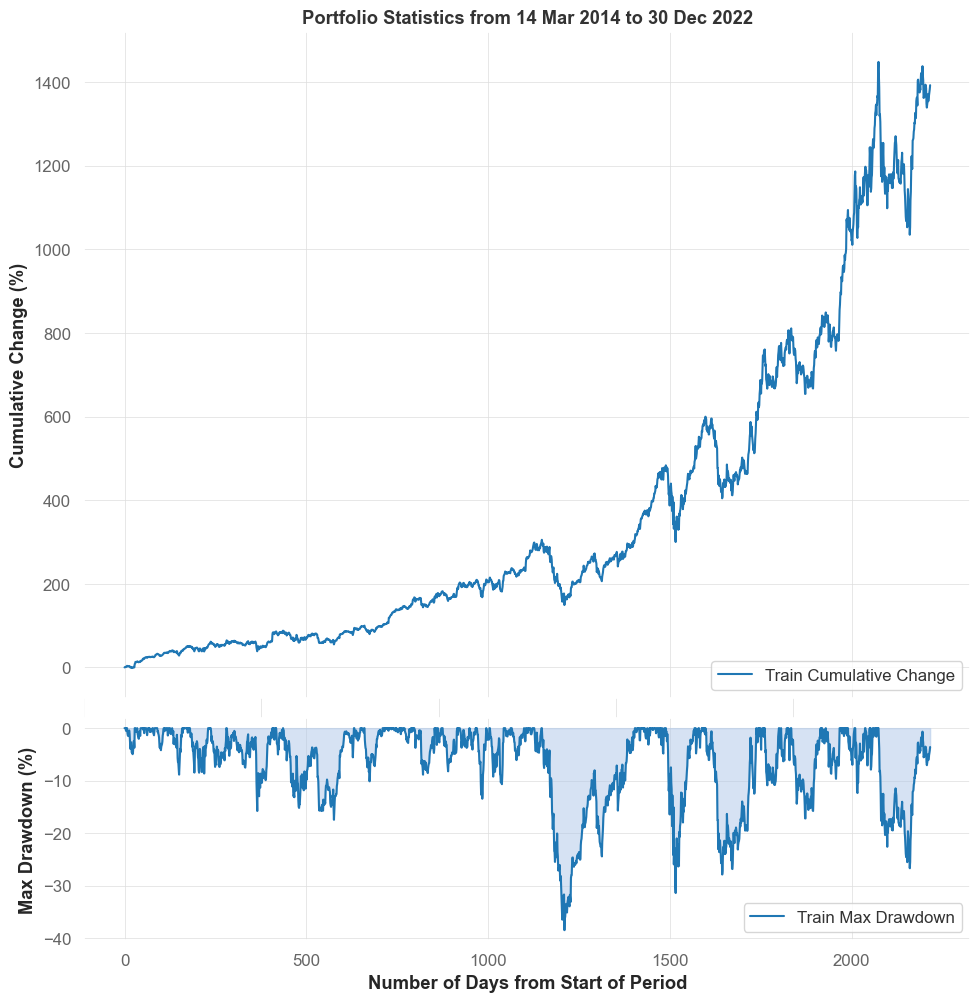

In [79]:

import matplotlib.pyplot as plt
import quantstats as qs
import matplotlib.gridspec as gridspec

metrics_rl = pd.read_csv("metrics_df_rl.csv")
metrics_train = pd.read_csv("metrics_data_train.csv")
metrics_test = pd.read_csv("metrics_data_test.csv")

def transform_df(df):
    df.reset_index(drop=False, inplace=True)  
    df.rename(columns={'index': 'row_number'}, inplace=True)

    def calculate_rowwise_max_drawdown(portfolio_values):
        portfolio_values = np.array(portfolio_values)
        max_drawdowns = np.zeros(len(portfolio_values))  # Array to hold max drawdowns for each time step
        running_max = -np.inf  # Initialize running max to negative infinity
        for i in range(len(portfolio_values)):
            # Update the running maximum
            running_max = max(running_max, portfolio_values[i])
            # Calculate drawdown for the current value
            drawdown = (portfolio_values[i] - running_max) / running_max
            # Store the maximum drawdown observed up to this point
            max_drawdowns[i] = drawdown if drawdown < 0 else 0  # Only store negative drawdowns
        return max_drawdowns

    df['max_drawdown'] = calculate_rowwise_max_drawdown(df['portfolio_values'])*100
    df['cumulative_change'] = ((df['portfolio_values'] - df['portfolio_values'][0])/df['portfolio_values'][0])*100
    return df

metrics_rl_plot = transform_df(metrics_rl)
metrics_train_plot = transform_df(metrics_train)
metrics_test_plot = transform_df(metrics_test)

def qs_plotter(df):
    train_color_cum =  "#1f77b4" 
    train_color_dd =   "#aec7e8"  
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    for ax in axs:
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.strftime("%d %b %Y")
    earliest_date = df['date'][0]
    latest_date = df['date'][len(df)-1]
    ax1 = fig.add_subplot(gs[0])  # Larger subplot
    ax1.plot(df['row_number'], df["cumulative_change"], "b", label='Train Cumulative Change', color = train_color_cum)
    ax1.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax1.set_ylabel("Cumulative Change (%)", fontweight='bold')
    ax1.legend(loc="lower right")  # Move legend to the right



    ax2 = fig.add_subplot(gs[1])  # Smaller subplot
    ax2.plot(df['row_number'], df["max_drawdown"], "r", label='Train Max Drawdown', color = train_color_cum)
    ax2.fill_between(df['row_number'], df["max_drawdown"], 0, 
                    color= train_color_dd, alpha=0.5)
    ax2.set_ylabel("Max Drawdown (%)", fontweight='bold')
    # ax2.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax2.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3 = fig.add_subplot(gs[2])  # Smaller subplot
    # ax3.plot(df['row_number'], df["returns"]*100, "b")
    # ax3.set_ylabel("Daily Return (%)", fontweight='bold')
    # ax3.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 > 0), color='green', alpha=0.3)
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 < 0), color='red', alpha=0.3)
    ax2.legend(loc="lower right") # Adding legend for cumulative change
    plt.tight_layout()
    ax1.set_title(f"Portfolio Statistics from {earliest_date} to {latest_date}", fontweight='bold')
    plt.close()
    return fig

plottrain = qs_plotter(metrics_train_plot)
plottrain


C:\Users\xutia\AppData\Local\Temp\ipykernel_21564\1427074563.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(df1['row_number'], df1["cumulative_change"], "b", label='RL Cumulative Change', color = rl_color_cum)
C:\Users\xutia\AppData\Local\Temp\ipykernel_21564\1427074563.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax1.plot(df2['row_number'], df2["cumulative_change"], "b", label='Test Cumulative Change', color = test_color_cum)
C:\Users\xutia\AppData\Local\Temp\ipykernel_21564\1427074563.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(0.7686274509803922, 0.3058

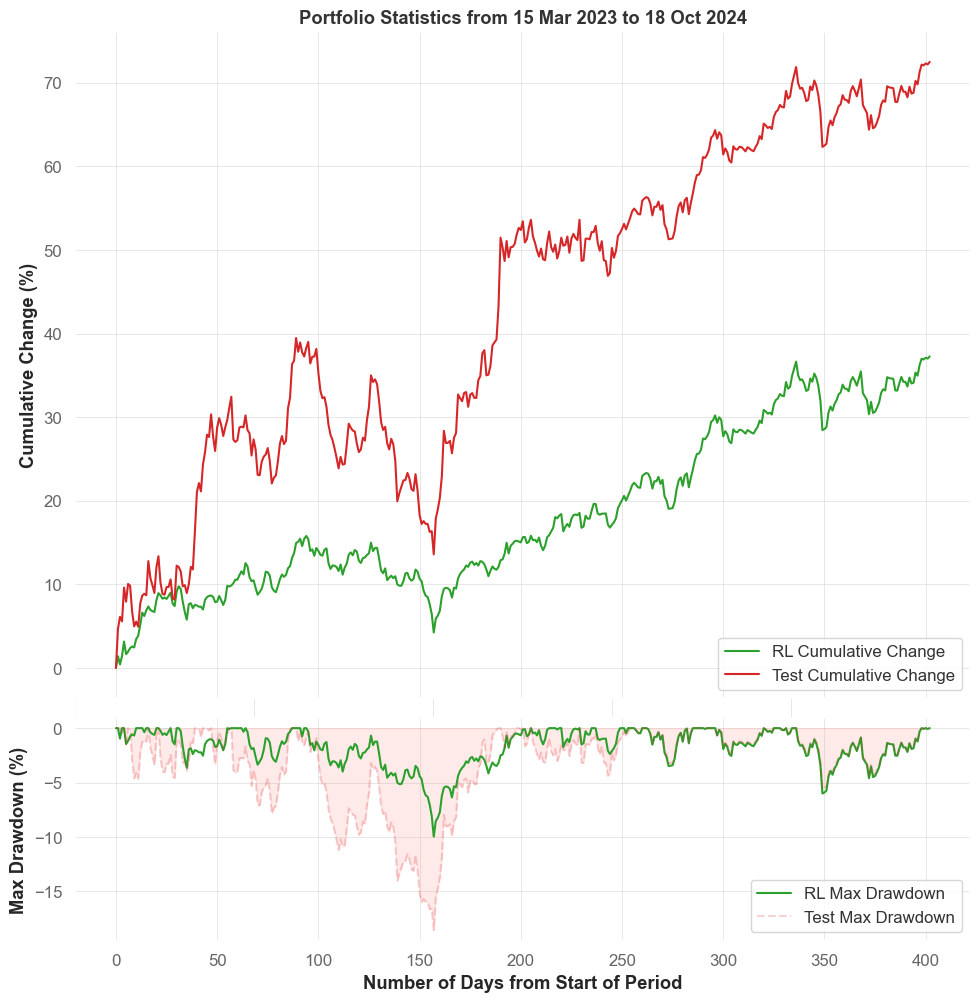

In [78]:
def qs_twoplots(df1, df2):


    rl_color_cum =   "#2ca02c"   
    train_color_cum =  "#1f77b4" 
    test_color_cum = "#d62728"

    rl_color_dd =   "#98df8a"
    train_color_dd =   "#aec7e8" 
    test_color_dd = "#ff9896"  


    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    for ax in axs:
        ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

    for df in [df1, df2]:
        df['date'] = pd.to_datetime(df['date'])
        df['date'] = df['date'].dt.strftime("%d %b %Y")



    earliest_date = min(df1['date'][0], df2['date'][0])
    latest_date = max(df1['date'][len(df1)-1], df2['date'][len(df2)-1])


    ax1 = fig.add_subplot(gs[0])  # Larger subplot
    ax1.plot(df1['row_number'], df1["cumulative_change"], "b", label='RL Cumulative Change', color = rl_color_cum)
    ax1.plot(df2['row_number'], df2["cumulative_change"], "b", label='Test Cumulative Change', color = test_color_cum)

    ax1.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax1.set_ylabel("Cumulative Change (%)", fontweight='bold')
    ax1.legend(loc="lower right")  # Move legend to the right


    ax2 = fig.add_subplot(gs[1])  # Smaller subplot
    ax2.plot(df1['row_number'], df1["max_drawdown"], "r", label='RL Max Drawdown', color = rl_color_cum, linestyle='-')
    # ax2.fill_between(df1['row_number'], df1["max_drawdown"], 0, 
    #                 color=rl_color_dd, alpha=0.2)
    
    ax2.plot(df2['row_number'], df2["max_drawdown"], "r", label='Test Max Drawdown', color = test_color_cum, linestyle='--', alpha = 0.2)
    ax2.fill_between(df2['row_number'], df2["max_drawdown"], 0, 
                    color=test_color_dd, alpha=0.2)
    
    ax2.legend(loc="lower right") # Adding legend for cumulative change




    ax2.set_ylabel("Max Drawdown (%)", fontweight='bold')
    # ax2.tick_params(axis='x', which='both', labelbottom=False, labelleft=False)
    ax2.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3 = fig.add_subplot(gs[2])  # Smaller subplot
    # ax3.plot(df['row_number'], df["returns"]*100, "b")
    # ax3.set_ylabel("Daily Return (%)", fontweight='bold')
    # ax3.set_xlabel("Number of Days from Start of Period", fontweight='bold')
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 > 0), color='green', alpha=0.3)
    # ax3.fill_between(df['row_number'], df["returns"] * 100, 0, 
    #                  where=(df["returns"] * 100 < 0), color='red', alpha=0.3)
    plt.tight_layout()
    ax1.set_title(f"Portfolio Statistics from {earliest_date} to {latest_date}", fontweight='bold')
    plt.close()
    return fig

plot1 = qs_twoplots(metrics_rl_plot, metrics_test_plot)
plot1


In [26]:
# len(metrics_rl_plot)
# len(metrics_train_plot)
metrics_test_plot 

,row_number,date,returns,rewards,portfolio_values,max_drawdown,cumulative_change
0,0,2023-03-15,0.000000,0.000000,100000.000000,0.000000,0.000000
1,1,2023-03-16,0.046789,-233.227478,104678.875000,0.000000,4.678875
2,2,2023-03-17,0.013735,-260.436001,106116.671875,0.000000,6.116672
3,3,2023-03-20,-0.005195,-240.965502,105565.359375,-0.519534,5.565359
4,4,2023-03-21,0.038318,-308.277300,109610.429688,0.000000,9.610430
...,...,...,...,...,...,...,...
398,398,2024-10-14,0.005181,-1954.436424,172165.187500,0.000000,72.165188
399,399,2024-10-15,-0.000571,-1957.458730,172066.953125,-0.057058,72.066953
400,400,2024-10-16,0.001398,-1960.519880,172307.546875,0.000000,72.307547
401,401,2024-10-17,-0.000697,-1963.491370,172187.421875,-0.069715,72.187422


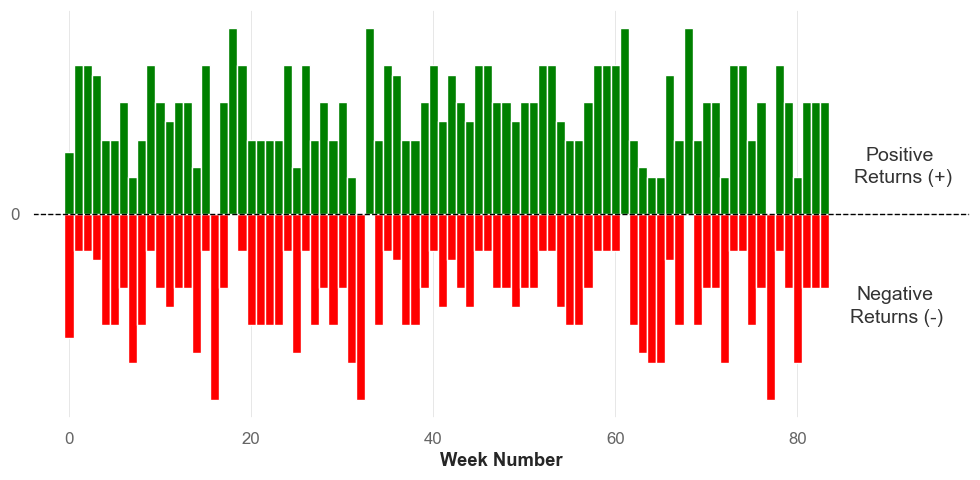

In [245]:
metrics_rl_plot['date'] = pd.to_datetime(metrics_rl_plot['date'])
metrics_rl_plot_monthly = (
    metrics_rl_plot.groupby(pd.Grouper(key='date', freq='W'))
    .agg(positive_returns=('returns', lambda x: (x > 0).sum()),  # Count positive returns
         total_days =('returns', 'size'))  # Count total weeks
    .reset_index()
)
# Calculate the proportion of positive returns
metrics_rl_plot_monthly['proportion_positive'] = metrics_rl_plot_monthly['positive_returns'] / metrics_rl_plot_monthly['total_days']

# Rename columns for clarity
metrics_rl_plot_monthly.rename(columns={'date': 'month', 'proportion_positive': 'proportion_of_positive_returns'}, inplace=True)
metrics_rl_plot_monthly['month'] = metrics_rl_plot_monthly['month'].dt.strftime("%b %Y")
metrics_rl_plot_monthly['row_number'] = range(len(metrics_rl_plot_monthly))
metrics_rl_plot_monthly['proportion_of_positive_returns'] = metrics_rl_plot_monthly['proportion_of_positive_returns'] * 100
metrics_rl_plot_monthly['red'] = 100 - metrics_rl_plot_monthly['proportion_of_positive_returns']
metrics_rl_plot_monthly['green'] = metrics_rl_plot_monthly['proportion_of_positive_returns']
# plt.plot(metrics_rl_plot_monthly['row_number'], metrics_rl_plot_monthly["proportion_of_positive_returns"]*100, "b")
fig, ax = plt.subplots(figsize=(10, 5))
# metrics_rl_plot_monthly
# Plotting stacked bars
row_number = metrics_rl_plot_monthly['row_number']
bar_width=1
# Plot the red portion (below 50%)
ax.bar(row_number, -metrics_rl_plot_monthly['red'], 
       bar_width, label='Negative Return', color='red')

# Plot the green portion (above 50%)
ax.bar(row_number, metrics_rl_plot_monthly['green'], 
       bar_width, label='Positive Return', color='green')

# Add a reference line at y=0 (which corresponds to the 50% mark)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Set axis labels and title
ax.set_xlabel("Week Number", fontweight='bold')
# ax.set_title("Win Rate of Portfolio by Week", fontweight='bold')
ax.set_yticks([0])  # Only show tick at 0
ax.set_yticklabels([0])  # Set the label for the tick

plt.annotate('Positive', (95, 25), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Negative', (95, -50), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Returns (+)', (97, 13), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
plt.annotate('Returns (-)', (96, -62), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
ax.set_xlim(left=-4, right=99)
# Remove y-axis labels and ticks (as they are not needed)
# ax.set_yticks([])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
plt.tight_layout()
plt.show()


C:\Users\wjlwi\AppData\Local\Temp\ipykernel_21676\2963437725.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  metrics_rl.groupby(pd.Grouper(key='date', freq='M'))


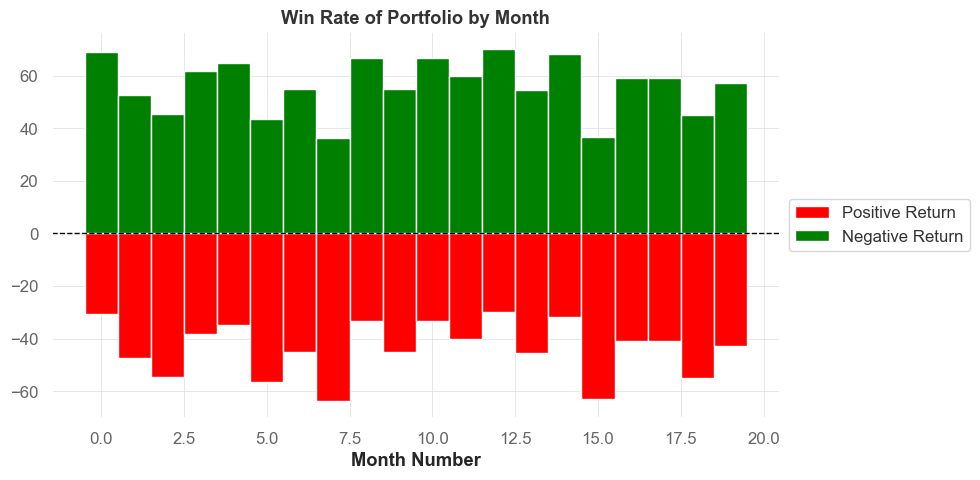

In [246]:
metrics_rl_plot_monthly = (
    metrics_rl.groupby(pd.Grouper(key='date', freq='M'))
    .agg(positive_returns=('returns', lambda x: (x > 0).sum()),  # Count positive returns
         total_days =('returns', 'size'))  # Count total weeks
    .reset_index()
)
# Calculate the proportion of positive returns
metrics_rl_plot_monthly['proportion_positive'] = metrics_rl_plot_monthly['positive_returns'] / metrics_rl_plot_monthly['total_days']

# Rename columns for clarity
metrics_rl_plot_monthly.rename(columns={'date': 'month', 'proportion_positive': 'proportion_of_positive_returns'}, inplace=True)
metrics_rl_plot_monthly['month'] = metrics_rl_plot_monthly['month'].dt.strftime("%b %Y")
metrics_rl_plot_monthly['row_number'] = range(len(metrics_rl_plot_monthly))
metrics_rl_plot_monthly['proportion_of_positive_returns'] = metrics_rl_plot_monthly['proportion_of_positive_returns'] * 100
metrics_rl_plot_monthly['red'] = 100 - metrics_rl_plot_monthly['proportion_of_positive_returns']
metrics_rl_plot_monthly['green'] = metrics_rl_plot_monthly['proportion_of_positive_returns']
# plt.plot(metrics_rl_plot_monthly['row_number'], metrics_rl_plot_monthly["proportion_of_positive_returns"]*100, "b")
fig, ax = plt.subplots(figsize=(10, 5))
# metrics_rl_plot_monthly
# Plotting stacked bars
row_number = metrics_rl_plot_monthly['row_number']
bar_width=1
# Plot the red portion (below 50%)
ax.bar(row_number, -metrics_rl_plot_monthly['red'], 
       bar_width, label='Positive Return', color='red')

# Plot the green portion (above 50%)
ax.bar(row_number, metrics_rl_plot_monthly['green'], 
       bar_width, label='Negative Return', color='green')

# Add a reference line at y=0 (which corresponds to the 50% mark)
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Set axis labels and title
ax.set_xlabel("Month Number", fontweight='bold')
ax.set_title("Win Rate of Portfolio by Month", fontweight='bold')

# Remove y-axis labels and ticks (as they are not needed)
# ax.set_yticks([])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# Show plot
plt.tight_layout()
plt.show()

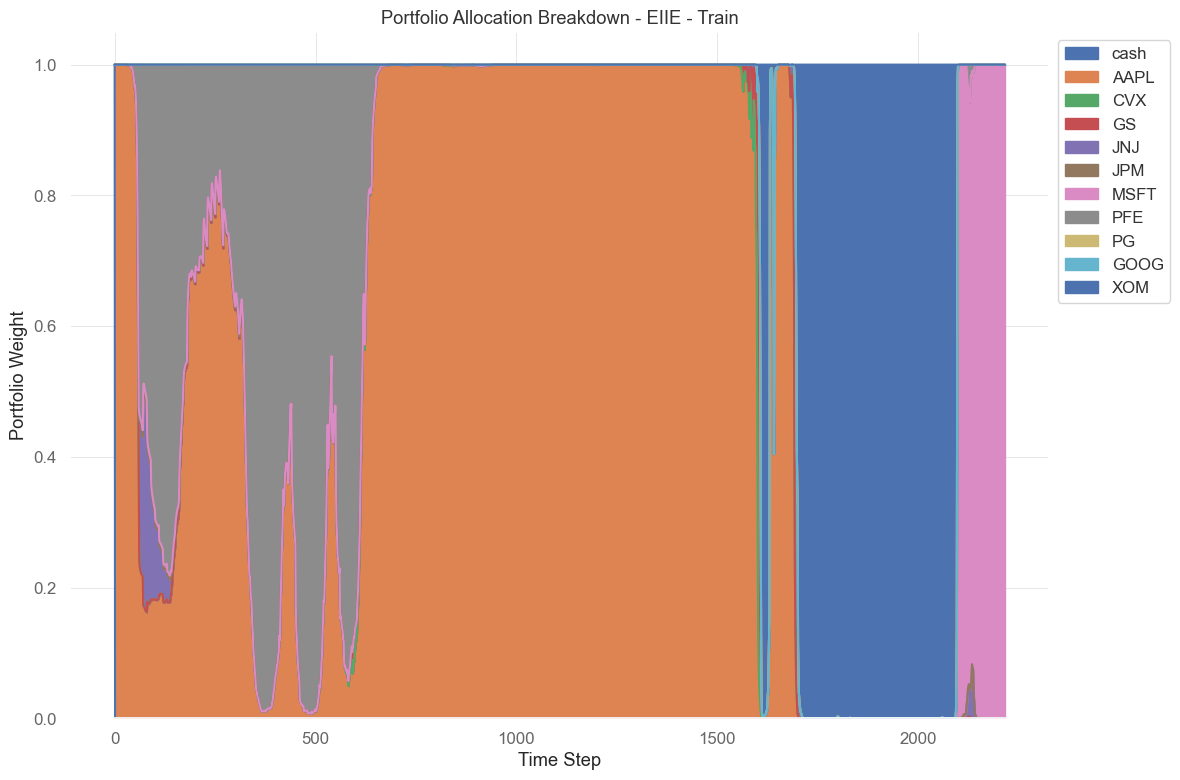

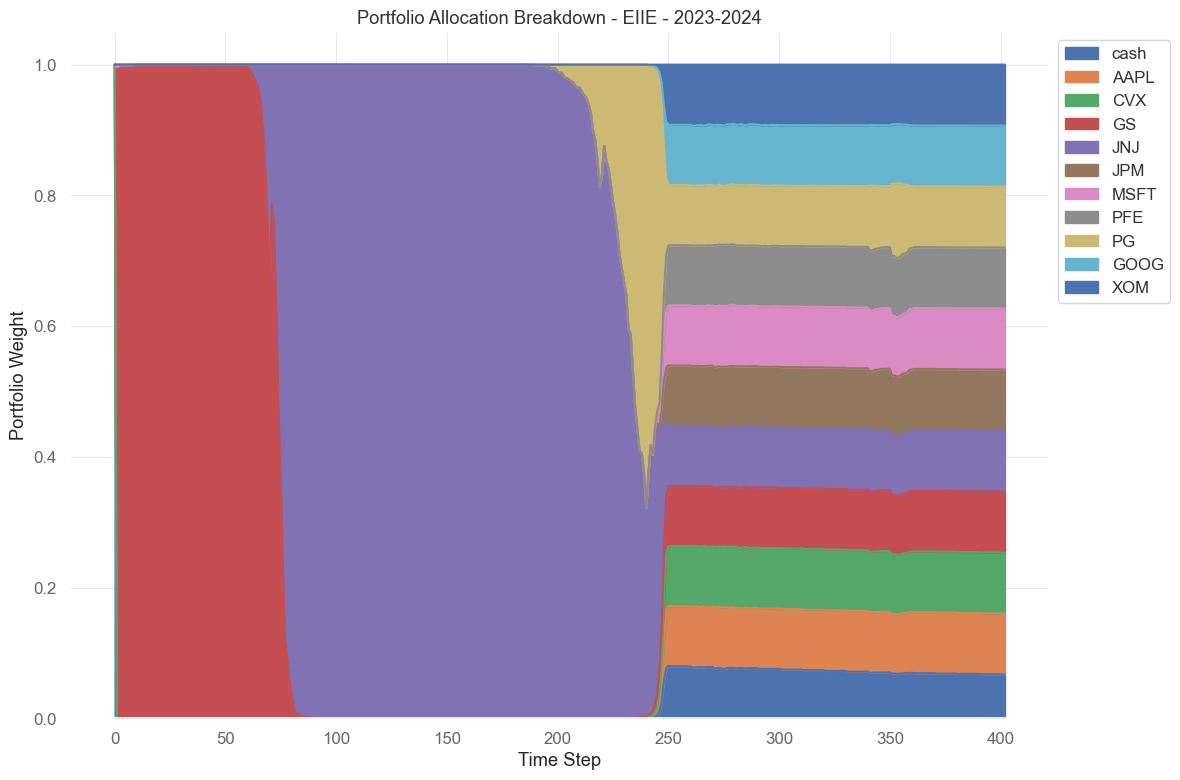

C:\Users\wjlwi\AppData\Local\Temp\ipykernel_21676\2798965853.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,TIME_WINDOW,K_SIZE,CONV_MID,CONV_FINAL,train_portfolio_value,train_drawdown,train_sharpe,train_cumulative,test_portfolio_value,test_drawdown,test_sharpe,test_cumulative
0,50,4,5,10,1492731.375,-0.385117,1.225798,14.927314,172487.140625,-0.185535,1.870612,1.724871


In [38]:
# Function to plot action memory
def plot_action_memory(actions, tickers, label):
    """Visualize portfolio allocation over time."""
    actions_df = pd.DataFrame(actions, columns=["cash"] + tickers)
    actions_df.plot(kind="area", figsize=(12, 8), title=f"Portfolio Allocation Breakdown - {label}")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Time Step")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot EIIE actions for the training period
plot_action_memory(EIIE_results["train"]["actions"], TEST_SET, "EIIE - Train")

# Plot EIIE actions for test
plot_action_memory(EIIE_results["test"]["actions"], TEST_SET, "EIIE - 2023-2024")

# Similarly, plot UBAH actions for each period
# plot_action_memory(UBAH_results["train"]["actions"], TEST_SET, "UBAH - Train")
# plot_action_memory(UBAH_results["2021"]["actions"], TEST_SET, "UBAH - 2021")
# plot_action_memory(UBAH_results["2022"]["actions"], TEST_SET, "UBAH - 2022")
# plot_action_memory(UBAH_results["2023"]["actions"], TEST_SET, "UBAH - 2023")

temp_df = pd.DataFrame([{
        "TIME_WINDOW": TIME_WINDOW, "K_SIZE": K_SIZE, "CONV_MID": CONV_MID, "CONV_FINAL": CONV_FINAL,
        "train_portfolio_value": train_final_value, "train_drawdown": train_drawdown, "train_sharpe": train_sharpe, "train_cumulative": train_cumulative,
        "test_portfolio_value": portfolio_test_value, "test_drawdown": drawdown_test, "test_sharpe": sharpe_test, "test_cumulative": cumulative_test}]
)
results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
results_df

In [82]:
results_df.to_csv('filename.csv', index=False)

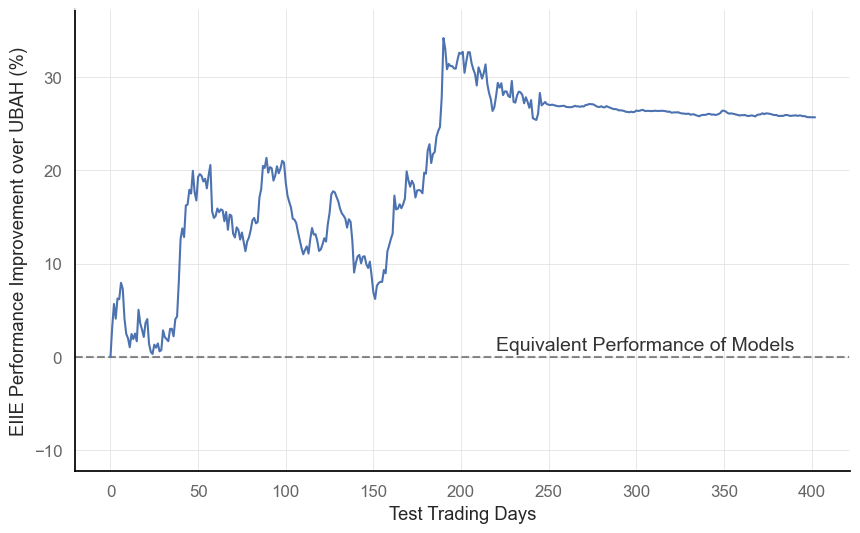

In [37]:
#diff =  EIIE_results["test"]["value"] - UBAH_results["test"]["value"]
normdiff = [(i -j)/j for i, j in zip(EIIE_results["test"]["value"], UBAH_results["test"]["value"])]
percentagediff = [i*100 for i in normdiff]
plt.axhspan(-10, 35, alpha=0)
#x axis line
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5) 
plt.annotate('Equivalent Performance of Models', (390, -0.025), textcoords="offset points", xytext=(0,5), ha='right', fontsize=14)
# plt.grid(False)

# Add solid lines for axes
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')

#add labels
plt.xlabel("Test Trading Days")
plt.ylabel("EIIE Performance Improvement over UBAH (%)")
plt.plot(percentagediff)

